# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [18]:
from graphviz import Digraph
import math

In [83]:
class Value:
    def __init__(self, data, _children= (), _op='', label = ''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __div__(self, other):
        out = Value(self.data / other.data, (self, other), '/')
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out


    def backward(self):
        # Topological order of nodes
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  # Seed the gradient

        for v in reversed(topo):
            v._backward()



In [84]:

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build (root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR - left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            dot. edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [85]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
b.grad = -4
a.grad = 6

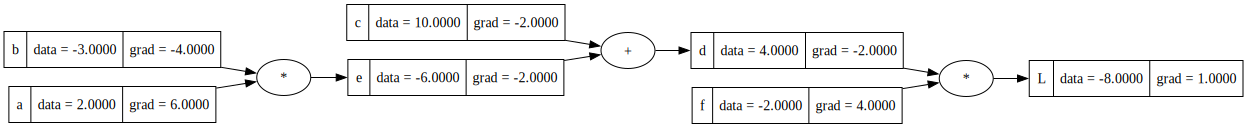

In [86]:
draw_dot(L)

In [87]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
bias = Value(6.8813735870195432, label = 'bias')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + bias; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [88]:
# manually set the gradient of the loss function with respect to the output of the network
o.grad = 1
# do / dn = (tanh(n))' = 1 - (tanh(n))^2 = 1 - (0.7071)^2 = 0.5
n.grad = 0.5

x1w1x2w2.grad = 0.5
bias.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = 0.0
x2.grad = 0.5

w1.grad = 1.0
x1.grad = -1.5

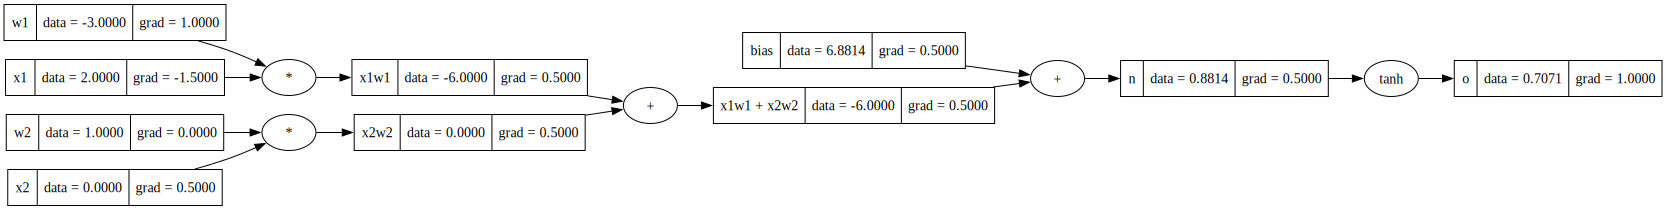

In [89]:
draw_dot(o)

In [90]:
# instead of manual setting of gradients, _backward method is used here.
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
bias = Value(6.8813735870195432, label = 'bias')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + bias; n.label = 'n'
o = n.tanh(); o.label = 'o'

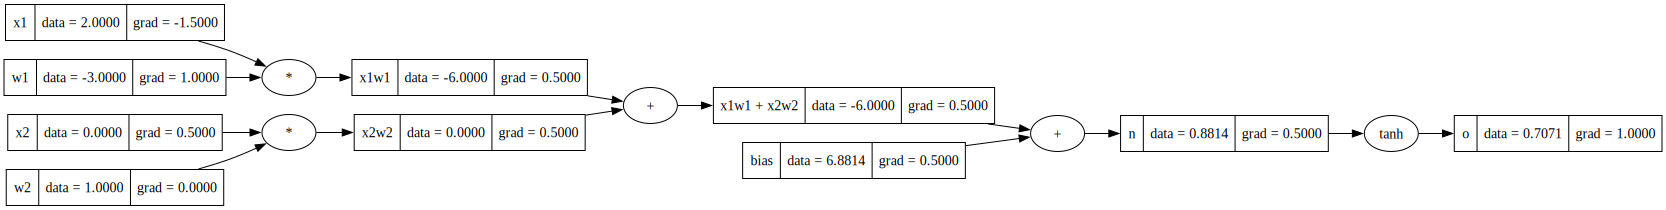

In [91]:
o.backward()

draw_dot(o)

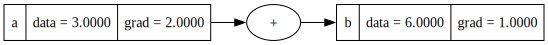

In [93]:
#testing multivariable bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)
# grad of a is shown as 1, which is incorrect
#gradient should be accumulative, implementation of gradients have to change to +=